# NESTML Ornstein-Uhlenbeck noise tutorial

In this tutorial, we will formulate the Ornstein-Uhlenbeck (O-U) noise process in NESTML and simulate it in NEST Simulator.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os
from pynestml.frontend.pynestml_frontend import to_nest, install_nest

NEST_SIMULATOR_INSTALL_LOCATION = "/home/charl/julich/nest-simulator-build"

## The Ornstein-Uhlenbeck process

The Ornstein-Uhlenbeck process is often used as a source of noise because it is well understood and has convenient properties (it is a Gaussian process, has the Markov property, and is stationary). Let the O-U process, denoted $U(t)$ (with $t\geq 0$) , be defined as the solution of the following stochastic differential equation:

\begin{align}
\frac{dU}{dt} = \frac{\mu - U}{\tau} + \sigma\sqrt{\frac 2 \tau} \frac{dB(t)}{dt}
\end{align}

The first right-hand side term is a "drift" term which is deterministic and slowly reverts $U_t$ to the mean $\mu$, with time constant $\tau$. The second term is stochastic as $B(t)$ is the Brownian motion (also "Wiener") process, and $\sigma>0$ is the standard deviation of the noise.

It turns out that the infinitesimal step in Brownian motion is white noise, that is, an independent and identically distributed sequence of Gaussian $\mathcal{N}(0, 1)$ random variables. The noise $dB(t)/dt$ can be sampled at time $t$ by drawing a sample from that Gaussian distribution, so if the process is sampled at discrete intervals of length $h$, we can write (equation 2.47 from [\[1\]](#References)):

\begin{align}
U(t + h) = (U(t) - \mu)\exp(-h/\tau) + \sigma\sqrt{(1 - \exp(-2h / \tau ))} \cdot\mathcal{N}(0, 1)
\end{align}

## Simulating the Ornstein-Uhlenbeck process with NESTML

### Formulating the model in NESTML

The O-U process is now defined as a stepwise update equation, that is carried out at each timestep. All statements contained in the NESTML ``update`` block are run at every timestep, so this is a natural place to place the O-U updates.

Updating the O-U process state requires knowledge about how much time has elapsed. As we will update the process once every simulation timestep, we pass this value by invoking the ``resolution()`` function.

In [2]:
nestml_ou_model = '''
neuron ornstein_uhlenbeck_noise:

parameters:
  mean_noise real = 500    # mean of the noise
  sigma_noise real = 50    # std. dev. of the noise
  tau_noise ms = 20 ms     # time constant of the noise
end

internals:
  A_noise real = sigma_noise * ((1 - exp(-2 * resolution() / tau_noise)))**.5
end

state:
  U real = mean_noise   # set the initial condition
end

update:
  U = mean_noise
      + (U - mean_noise) * exp(-resolution() / tau_noise)
      + A_noise * random_normal(0, 1)
end

end
'''

Save to a temporary file and make the model available to instantiate in NEST:

In [3]:
with open("ornstein_uhlenbeck_noise.nestml", "w") as nestml_model_file:
    print(nestml_ou_model, file=nestml_model_file)

to_nest(input_path="ornstein_uhlenbeck_noise.nestml",
        target_path="/tmp/nestml-ou-noise-target",
        module_name="nestml_ou_module",
        suffix="_nestml",
        logging_level="INFO")
install_nest("/tmp/nestml-ou-noise-target", NEST_SIMULATOR_INSTALL_LOCATION)
nest.Install("nestml_ou_module")

[1,GLOBAL, INFO]: Start processing '/home/charl/temp/ornstein_uhlenbeck_noise.nestml'!
ANTLR runtime and generated code versions disagree: 4.8!=4.7.1
ANTLR runtime and generated code versions disagree: 4.8!=4.7.1
[2,ornstein_uhlenbeck_noise_nestml, WARNING, [2:0;24:0]]: Input block not defined!
[3,ornstein_uhlenbeck_noise_nestml, WARNING, [2:0;24:0]]: Output block not defined!
[4,ornstein_uhlenbeck_noise_nestml, INFO, [2:0;24:0]]: Start building symbol table!
[5,ornstein_uhlenbeck_noise_nestml, INFO, [5:20;5:20]]: Implicit casting from (compatible) type 'integer' to 'real'.
[6,ornstein_uhlenbeck_noise_nestml, INFO, [6:21;6:21]]: Implicit casting from (compatible) type 'integer' to 'real'.
[7,GLOBAL, INFO]: Analysing/transforming neuron 'ornstein_uhlenbeck_noise_nestml'
[8,ornstein_uhlenbeck_noise_nestml, INFO, [2:0;24:0]]: Starts processing of the neuron 'ornstein_uhlenbeck_noise_nestml'
[9,ornstein_uhlenbeck_noise_nestml, INFO, [2:0;24:0]]: Successfully generated code for the neuron: 

### Running the simulation in NEST

Let's define a function that will instantiate and set parameters for the O-U model, run a simulation, and plot and return the results.

In [81]:
def evaluate_ou_process(h: float=.1, t_sim:float=100., neuron_parms=None, title=None, plot=True):
    """
    h : float
        timestep in ms
    t_sim : float
        total simulation time in ms
    """
    nest.ResetKernel()
    nest.SetKernelStatus({"resolution": h})
    neuron = nest.Create("ornstein_uhlenbeck_noise_nestml")

    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)
            
    multimeter = nest.Create("multimeter")
    multimeter.set({"record_from": ["U"],                     "interval": h})
    nest.Connect(multimeter, neuron)
    
    nest.Simulate(t_sim)

    dmm = nest.GetStatus(multimeter)[0]
    U = dmm["events"]["U"]
    timevec = dmm["events"]["times"]
    
    if plot:
        fig, ax = plt.subplots(figsize=(12., 5.))
        if title is not None:
            fig.suptitle(title)
        ax.plot(timevec, U)
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("U")
        ax.set_xlim(0., t_sim)
        ax.grid()
    
    return timevec, U

Then, we can run the process. Hint: play with the parameters a bit here and see the effects it has on the returned timeseries.

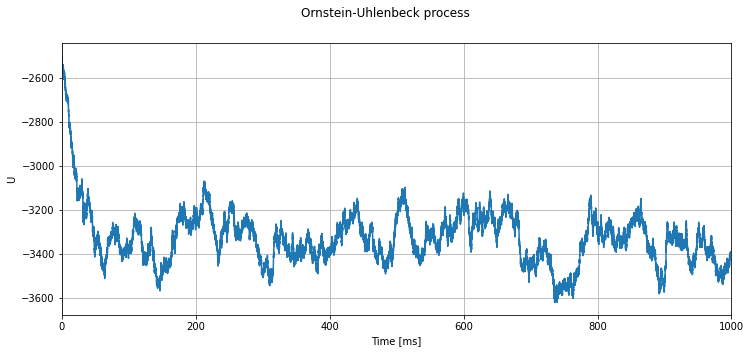

In [82]:
timevec, U = evaluate_ou_process(h=_h,
                                 t_sim=1000.,
                                 neuron_parms={"U" : -2500.,
                                               "mean_noise": -3333.,
                                               "tau_noise": 20.,
                                               "sigma_noise": 100.},
                                title=r"Ornstein-Uhlenbeck process")


### Correctness test based on predicting variance

We can predict the variance of the timeseries as:
    
\begin{align}
\text{Var}(U) = \frac{\sigma^2 \tau}{2h} (1 - \exp(-2 h / \tau))
\end{align}

and run a consistency check across parameters to make sure that our prediction matches the result derived from the timeseries generated by sampling the process.

In [83]:
h = [.01, .1, 1.]
tau_noise = [10., 100., 1000.]
sigma_noise = [0., 10., 100., 1000.]

max_rel_error = .25   # yes, this is pretty terrible!
                      # Need a very long integration time (esp. for large tau)
                      # to get a tighter bound.

for _h in h:
    for _tau_noise in tau_noise:
        for _sigma_noise in sigma_noise:
            print("For h = " + str(_h) + ", tau_noise = " + str(_tau_noise) + ", sigma_noise = " + str(_sigma_noise))
            c = (_sigma_noise * np.sqrt(2 / _tau_noise))**2
            timevec, U = evaluate_ou_process(h=_h,
                                             t_sim=10000.,
                                             neuron_parms={"U" : 0.,
                                                           "mean_noise": 0.,
                                                           "tau_noise": _tau_noise,
                                                           "sigma_noise": _sigma_noise},
                                            title=r"Ornstein-Uhlenbeck process ($\tau$=" + str(_tau_noise) + ", $\sigma$=" + str(_sigma_noise) + ")",
                                            plot=False)
            #timevec, U = evaluate_ou_process(h=_h, t_sim=10000., neuron_parms={"U" : 0., "mean_noise": 0., "tau_noise": tau_noise, "sigma_noise": _sigma_noise * ((1 - np.exp(-2 * h / _tau_noise)))**.5})
            var_actual = np.var(U)
            print("Actual variance: " + str(var_actual)
            var_expected = _sigma_noise**2 * _tau_noise / (2 * _h) * (1 - np.exp(-2 * _h / _tau_noise))
            print("Expected variance: " + str(var_expected))
            if var_actual < 1E-15:
                assert var_expected < 1E-15
            else:
                assert np.abs(var_expected - var_actual) / (var_expected + var_actual) < max_rel_error

For h = 0.01, tau_noise = 10.0, sigma_noise = 0.0
Actual std dev = 0.0
Expected std dev: 0.0
For h = 0.01, tau_noise = 10.0, sigma_noise = 10.0
Actual std dev = 10.434079045201797
Expected std dev: 9.995002082708439
For h = 0.01, tau_noise = 10.0, sigma_noise = 100.0
Actual std dev = 104.34079045201797
Expected std dev: 99.9500208270844
For h = 0.01, tau_noise = 10.0, sigma_noise = 1000.0
Actual std dev = 1043.4079045201797
Expected std dev: 999.5002082708439
For h = 0.01, tau_noise = 100.0, sigma_noise = 0.0
Actual std dev = 0.0
Expected std dev: 0.0
For h = 0.01, tau_noise = 100.0, sigma_noise = 10.0
Actual std dev = 11.194766573777526
Expected std dev: 9.999500020832425
For h = 0.01, tau_noise = 100.0, sigma_noise = 100.0
Actual std dev = 111.94766573777534
Expected std dev: 99.99500020832424
For h = 0.01, tau_noise = 100.0, sigma_noise = 1000.0
Actual std dev = 1119.476657377754
Expected std dev: 999.9500020832425
For h = 0.01, tau_noise = 1000.0, sigma_noise = 0.0
Actual std dev =

### Autocorrelogram

If we plot the autocorrelogram, we should find high correlations only for lags lower than $\tau$.

Let's look at a process with $\tau=1000$:

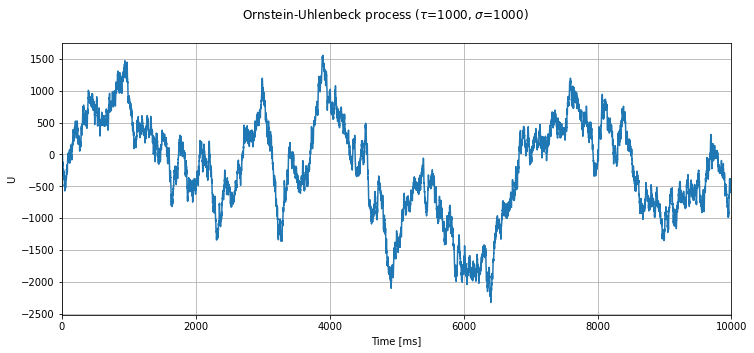

In [86]:
timevec, U = evaluate_ou_process(h=_h,
                                 t_sim=10000.,
                                 neuron_parms={"U" : 0.,
                                               "mean_noise": 0.,
                                               "tau_noise": 1000.,
                                               "sigma_noise": 1000.},
                                title=r"Ornstein-Uhlenbeck process ($\tau$=1000, $\sigma$=1000)")

[1.000e+00 2.000e+00 3.000e+00 ... 9.997e+03 9.998e+03 9.999e+03]


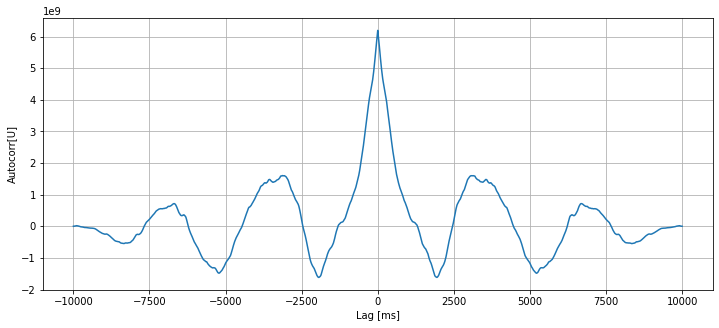

In [87]:
def autocorr(x):
    return np.correlate(x, x, mode='full')

fig, ax = plt.subplots(figsize=(12., 5.))
U_autocorr = autocorr(U)
lags = np.arange(len(U_autocorr)) - len(U_autocorr) / 2
ax.plot(lags, U_autocorr)
ax.set_xlabel("Lag [ms]")
ax.set_ylabel("Autocorr[U]")
ax.grid()
print(timevec)


## Integrating Ornstein-Uhlenbeck noise into a NESTML integrate-and-fire neuron

Now, the O-U noise process is integrated into an existing NESTML model, as an extra somatic current $I_{noise}$. In this example, w use the integrate-and-fire neuron with current based synapses and an exponentially shaped synaptic kernel, and no refractoriness mechanism.

This neuron can be written in just a few lines of NESTML:


In [78]:
iaf_psc_exp = '''
neuron iaf_psc_exp:

  initial_values:
    V_m mV = E_L
  end
  
  equations:
    kernel psc_kernel = exp(-t / tau_syn)
    V_m' = -(V_m - E_L) / tau_m + (convolve(psc_kernel, spikes) + I_e) / C_m
  end

  parameters:
    E_L mV = -65 mV      # resting potential
    I_e pA = 0 pA        # constant external input current
    tau_m ms = 25 ms     # membrane time constant
    tau_syn ms = 5 ms    # synaptic time constant
    C_m uF = 1 uF        # membrane capacitance
    V_theta mV = -30 mV  # threshold potential
  end

  input:
    spikes pA <- spike
  end
  
  output: spike
  
  update:
    integrate_odes()
    if V_m > V_theta:
      V_m = E_L
      emit_spike()
    end
  end

end
'''


In [79]:
with open("iaf_psc_exp.nestml", "w") as nestml_model_file:
    print(iaf_psc_exp, file=nestml_model_file)

to_nest(input_path="iaf_psc_exp.nestml",
        target_path="/tmp/nestml-target",
        module_name="nestml_iaf_module",
        suffix="_nestml")
install_nest("/tmp/nestml-target", NEST_SIMULATOR_INSTALL_LOCATION)
nest.Install("nestml_iaf_psc_alpha_module")

ANTLR runtime and generated code versions disagree: 4.8!=4.7.1
ANTLR runtime and generated code versions disagree: 4.8!=4.7.1


TypeError: analysis() got an unexpected keyword argument 'disable_stiffness_check'

Now, the NESTML model is ready to be used in a simulation.

In [4]:
def evaluate_neuron(neuron_name, neuron_parms=None, stimulus_type="constant",
                    mu=500., sigma=0., t_sim=300., plot=True):
    """
    Run a simulation in NEST for the specified neuron. Inject a stepwise
    current and plot the membrane potential dynamics and spikes generated.
    """
    dt = .1   # [ms]

    nest.ResetKernel()
    neuron = nest.Create(neuron_name)
    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)
    
    if stimulus_type == "constant":
        nest.SetStatus(neuron, "I_e", mu)
        assert sigma == 0.
    elif stimulus_type == "Ornstein-Uhlenbeck":
        nest.SetStatus(neuron, "I_noise0", mu)
        nest.SetStatus(neuron, "sigma_noise", sigma)
    else:
        raise Exception("Unknown stimulus type: " + str(stimulus_type))
    
    multimeter = nest.Create("multimeter")
    multimeter.set({"record_from": ["V_m"],
                    "interval": dt})
    spikedetector = nest.Create("spike_detector")
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spikedetector)
    
    nest.Simulate(t_sim)

    dmm = nest.GetStatus(multimeter)[0]
    Voltages = dmm["events"]["V_m"]
    tv = dmm["events"]["times"]
    dSD = nest.GetStatus(spikedetector, keys='events')[0]
    spikes = dSD['senders']
    ts = dSD["times"]
    
    _idx = [np.argmin((tv - spike_time)**2) - 1 for spike_time in ts]
    V_m_at_spike_times = Voltages[_idx]
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(tv, Voltages)
        ax.scatter(ts, V_m_at_spike_times)
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("V_m [mV]")
        ax.grid()

    return ts

array([ 13.9,  29.8,  45.7,  61.6,  77.5,  93.4, 109.3, 125.2, 141.1,
       157. , 172.9, 188.8, 204.7, 220.6, 236.5, 252.4, 268.3, 284.2])

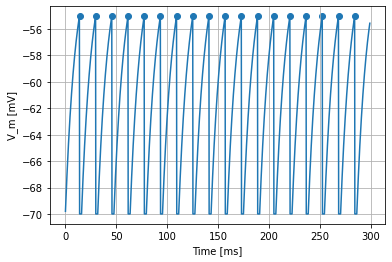

In [5]:
evaluate_neuron("iaf_psc_exp_nestml")

Now, for the same $\mu$=500 pA, but setting $\sigma$=200 pA/√ms, the effect of the noise can be clearly seen in the membrane potential trace and in the spiking irregularity: 

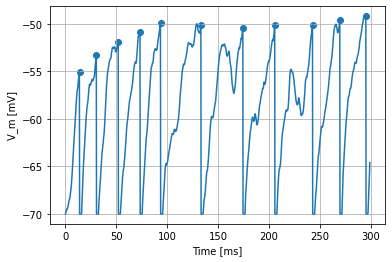

In [16]:
spike_times = evaluate_neuron("iaf_psc_alpha_adapt_thresh_OU_nestml",
                              stimulus_type="Ornstein-Uhlenbeck",
                              mu=500.,
                              sigma=200.)

Let's first do a sanity check and plot a distribution of the interspike intervals, as well as their mean and standard deviation interval.

Mean: 35.51174377224199
Std. dev.: 16.383833630520275


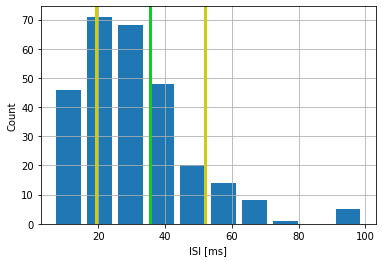

In [17]:
spike_times = evaluate_neuron("iaf_psc_alpha_OU_nestml",
                              stimulus_type="Ornstein-Uhlenbeck",
                              mu=500.,
                              sigma=200.,
                              t_sim=10000.,
                              plot=False)

ISI = np.diff(spike_times)
ISI_mean = np.mean(ISI)
ISI_std = np.std(ISI)

print("Mean: " + str(ISI_mean))
print("Std. dev.: " + str(ISI_std))

count, bin_edges = np.histogram(ISI)

fig, ax = plt.subplots()
ax.bar(bin_edges[:-1], count, width=.8 * (bin_edges[1] - bin_edges[0]))
ylim = ax.get_ylim()
ax.plot([ISI_mean, ISI_mean], ax.get_ylim(), c="#11CC22", linewidth=3)
ax.plot([ISI_mean - ISI_std, ISI_mean - ISI_std], ylim, c="#CCCC11", linewidth=3)
ax.plot([ISI_mean + ISI_std, ISI_mean + ISI_std], ylim, c="#CCCC11", linewidth=3)
ax.set_ylim(ylim)
ax.set_xlabel("ISI [ms]")
ax.set_ylabel("Count")
ax.grid()


The CV is defined as the standard deviation of the ISIs divided by the mean:

\begin{align}
CV = \frac{\langle (T-\langle T \rangle)^2 \rangle}{\langle T \rangle} = \frac{\sigma}{\mu}
\end{align}

Comment on whether the coefficient of variation is an appropriate metric to use.

**Task:** The skewness coefficient (SK) is a measure of the asymmetry of the ISI distribution, defined as:

\begin{align}
SK = \frac{\langle (T-\langle T \rangle)^3 \rangle}{\left\langle(T - \langle T \rangle)^2\right\rangle^{3/2}}
\end{align}

Write a function that takes the array of ISIs and computes the SK.

Now, we can use the ISIs to calculate the coefficient of variation. Sanity check: Poisson process should have CV = 1 irrespective of the rate.

In [18]:
mean_interval = 1.
isi = np.random.exponential(mean_interval, 1000)
print("For a Poisson process:")
print("CV = " + str(np.std(isi) / np.mean(isi)))

For a Poisson process:
CV = 1.0025890118681824


In [19]:
CV = np.std(ISI) / np.mean(ISI)
print("CV: " + str(np.std(ISI) / np.mean(ISI)))


CV: 0.4613638163081931


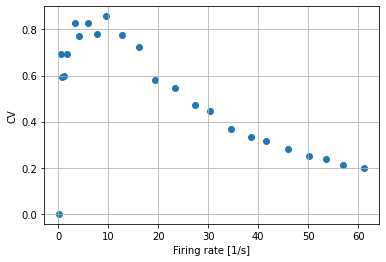

In [26]:
N = 40
t_sim = 10E3  # [ms]
CV = np.nan * np.ones(N)
rate = np.nan * np.ones(N)
for i, mu in enumerate(np.logspace(np.log10(150.), np.log10(500.), N)):
    spike_times = evaluate_neuron("iaf_psc_alpha_adapt_thresh_OU_nestml",
                                  stimulus_type="Ornstein-Uhlenbeck",
                                  mu=mu,
                                  sigma=100.,
                                  t_sim=t_sim,
                                  plot=False,
                                  neuron_parms={"Delta_Theta" : 0.})

    rate[i] = len(spike_times) / (t_sim / 1E3)

    ISI = np.diff(spike_times)
    if len(ISI) > 0:
        ISI_mean = np.mean(ISI)
        ISI_std = np.std(ISI)
        CV[i] = ISI_std / ISI_mean

fig, ax = plt.subplots()
ax.scatter(rate, CV)
ax.set_xlabel("Firing rate [1/s]")
ax.set_ylabel("CV")
ax.grid()

Let's compare this to the non-adapting model:

References
----------

[1] D.T. Gillespie, "The mathematics of Brownian motion and Johnson noise", Am. J. Phys. 64, 225 (1996); doi: 10.1119/1.18210











Acknowledgements
----------------

Thanks to Barna Zajzon, Renato Duarte and all participants of the CNS2020 tutorial on NEST Desktop & NESTML!

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270 and No. 785907 (Human Brain Project SGA1 and SGA2).

License
-------

This notebook (and associated files) is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

This notebook (and associated files) is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.